In [1]:
# Section 2: Optimization and Training (NumPy core)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


In [2]:
# MNIST via OpenML (NumPy arrays)
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

X_train, y_train = X[:60000], y[:60000]
X_test,  y_test  = X[60000:], y[60000:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(60000, 784) (60000,) (10000, 784) (10000,)


In [3]:
# Helpers: softmax, cross-entropy, accuracy, batching
def softmax(logits):
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / np.sum(exp, axis=1, keepdims=True)

def one_hot(y, C):
    oh = np.zeros((len(y), C), dtype=np.float32)
    oh[np.arange(len(y)), y] = 1.0
    return oh

def cross_entropy(probs, y):
    eps = 1e-12
    p = np.clip(probs[np.arange(len(y)), y], eps, 1.0)
    return -np.mean(np.log(p))

def accuracy(probs, y):
    return np.mean(np.argmax(probs, axis=1) == y)

def iterate_minibatches(X, y, batch_size=128, shuffle=True):
    n = len(X)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for start in range(0, n, batch_size):
        b = idx[start:start+batch_size]
        yield X[b], y[b]


In [4]:
# 2-layer MLP (for derivation + gradient checking + optimizers)
def relu(z): 
    return np.maximum(0, z)

def drelu(z):
    return (z > 0).astype(z.dtype)

class TwoLayerNet:
    def __init__(self, d_in=784, d_hidden=128, d_out=10, seed=42):
        rng = np.random.default_rng(seed)
        # He init for ReLU
        self.W1 = rng.normal(0, np.sqrt(2.0/d_in), size=(d_in, d_hidden)).astype(np.float32)
        self.b1 = np.zeros((1, d_hidden), dtype=np.float32)
        self.W2 = rng.normal(0, np.sqrt(1.0/d_hidden), size=(d_hidden, d_out)).astype(np.float32)
        self.b2 = np.zeros((1, d_out), dtype=np.float32)

    def forward(self, X, return_cache=False):
        # Forward pass: X -> hidden -> logits -> softmax
        Z1 = X @ self.W1 + self.b1
        A1 = relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        P = softmax(Z2)
        if return_cache:
            cache = {"X": X, "Z1": Z1, "A1": A1, "Z2": Z2, "P": P}
            return P, cache
        return P

    def loss(self, X, y):
        P = self.forward(X)
        return cross_entropy(P, y)

    def backward(self, cache, y):
        # Backprop from derivation (softmax+CE)
        X, Z1, A1, P = cache["X"], cache["Z1"], cache["A1"], cache["P"]
        N = len(y)
        Y = one_hot(y, P.shape[1])

        dZ2 = (P - Y) / N
        dW2 = A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * drelu(Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return grads


# 2.2.1 Backpropagation Derivation (2-layer network)

We derive backpropagation equations for a 2-layer Multilayer Perceptron (MLP).

---

## Network definition

**Input:**
$$
X \in \mathbb{R}^{N \times d}
$$

**Hidden layer:**
$$
Z_1 = X W_1 + b_1
$$
$$
A_1 = \phi(Z_1)
$$

**Output layer (logits):**
$$
Z_2 = A_1 W_2 + b_2
$$

**Softmax probabilities:**
$$
P = \text{softmax}(Z_2)
$$

**Cross-entropy loss:**
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log P_{i, y_i}
$$

---

## Step 1: Softmax + Cross-Entropy Gradient

For a single sample with one-hot encoded label \(Y\):

$$
L = -\sum_k Y_k \log P_k
$$

A well-known result for softmax combined with cross-entropy:

$$
\frac{\partial L}{\partial Z_2} = P - Y
$$

Averaged over the batch:

$$
dZ_2 = \frac{1}{N}(P - Y)
$$

---

## Step 2: Gradients of Layer 2 Parameters

Given:
$$
Z_2 = A_1 W_2 + b_2
$$

Gradients:

$$
dW_2 = A_1^T dZ_2
$$

$$
db_2 = \sum_{i=1}^{N} dZ_{2,i}
$$

$$
dA_1 = dZ_2 W_2^T
$$

---

## Step 3: Backpropagation Through Activation

Hidden activation:
$$
A_1 = \phi(Z_1)
$$

Element-wise gradient:
$$
dZ_1 = dA_1 \odot \phi'(Z_1)
$$

---

## Step 4: Gradients of Layer 1 Parameters

Given:
$$
Z_1 = X W_1 + b_1
$$

Gradients:

$$
dW_1 = X^T dZ_1
$$

$$
db_1 = \sum_{i=1}^{N} dZ_{1,i}
$$

---

## Final Backpropagation Equations

$$
dZ_2 = \frac{1}{N}(P - Y)
$$

$$
dW_2 = A_1^T dZ_2, \quad db_2 = \sum dZ_2
$$

$$
dA_1 = dZ_2 W_2^T
$$

$$
dZ_1 = dA_1 \odot \phi'(Z_1)
$$

$$
dW_1 = X^T dZ_1, \quad db_1 = \sum dZ_1
$$

In [12]:
# 2.2.2 Gradient Checking (5 pts)
# Numerical gradient (finite differences) + relative error
def eval_loss_with_params(net, X, y):
    return net.loss(X, y)

def numeric_gradient(net, X, y, param_name, eps=1e-5, max_checks=50, seed=42):
    """
    Compute numerical gradient for a subset of entries (for speed).
    Uses central difference: (f(x+eps)-f(x-eps))/(2eps)
    """
    rng = np.random.default_rng(seed)
    param = getattr(net, param_name)
    grad_num = np.zeros_like(param)

    # pick random indices to check
    flat_size = param.size
    check_ids = rng.choice(flat_size, size=min(max_checks, flat_size), replace=False)

    base = param.reshape(-1)
    grad_flat = grad_num.reshape(-1)

    for idx in check_ids:
        old = base[idx]

        base[idx] = old + eps
        loss_plus = eval_loss_with_params(net, X, y)

        base[idx] = old - eps
        loss_minus = eval_loss_with_params(net, X, y)

        base[idx] = old
        grad_flat[idx] = (loss_plus - loss_minus) / (2 * eps)

    return grad_num, check_ids

def relative_error(a, b, eps=1e-12):
    # ||a-b|| / (||a|| + ||b||)
    num = np.linalg.norm(a - b)
    den = np.linalg.norm(a) + np.linalg.norm(b) + eps
    return num / den


In [13]:
# Gradient checking on a small batch (fast)
net = TwoLayerNet(d_in=784, d_hidden=64, d_out=10, seed=42)

X_small = X_train[:128]
y_small = y_train[:128]

P, cache = net.forward(X_small, return_cache=True)
grads = net.backward(cache, y_small)

for pname in ["W1", "b1", "W2", "b2"]:
    gnum, ids = numeric_gradient(net, X_small, y_small, pname, eps=1e-5, max_checks=30)
    gan  = grads[pname]

    # compare only checked indices
    gnum_flat = gnum.reshape(-1)[ids]
    gan_flat  = gan.reshape(-1)[ids]

    err = relative_error(gnum_flat, gan_flat)
    print(f"{pname}: relative error = {err:.3e} (checked {len(ids)} entries)")


W1: relative error = 3.650e-01 (checked 30 entries)
b1: relative error = 2.837e-01 (checked 30 entries)
W2: relative error = 2.118e-01 (checked 30 entries)
b2: relative error = 6.620e-02 (checked 10 entries)


In [14]:
# 2.2.3 Optimizers Comparison (10 pts)
# Optimizers from scratch: SGD, RMSprop, Adam
class SGD:
    def __init__(self, lr=0.1):
        self.lr = lr

    def step(self, params, grads):
        for k in params:
            params[k] -= self.lr * grads[k]

class RMSprop:
    def __init__(self, lr=0.001, beta=0.9, eps=1e-8):
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.v = {}

    def step(self, params, grads):
        for k in params:
            if k not in self.v:
                self.v[k] = np.zeros_like(params[k])
            self.v[k] = self.beta * self.v[k] + (1 - self.beta) * (grads[k] ** 2)
            params[k] -= self.lr * grads[k] / (np.sqrt(self.v[k]) + self.eps)

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, params, grads):
        self.t += 1
        for k in params:
            if k not in self.m:
                self.m[k] = np.zeros_like(params[k])
                self.v[k] = np.zeros_like(params[k])
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * grads[k]
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (grads[k] ** 2)

            # bias correction
            mhat = self.m[k] / (1 - self.beta1 ** self.t)
            vhat = self.v[k] / (1 - self.beta2 ** self.t)

            params[k] -= self.lr * mhat / (np.sqrt(vhat) + self.eps)


In [15]:
# Learning rate schedules (impact on convergence)
def lr_constant(base_lr, epoch): 
    return base_lr

def lr_step_decay(base_lr, epoch, step=5, gamma=0.5):
    # every "step" epochs: lr *= gamma
    return base_lr * (gamma ** (epoch // step))

def lr_cosine(base_lr, epoch, max_epoch):
    # cosine annealing from base_lr to ~0
    return base_lr * 0.5 * (1 + np.cos(np.pi * epoch / max_epoch))


In [16]:
# Training loop for optimizer comparison (same model, different optimizers)
def train_with_optimizer(opt_name="sgd", schedule="constant", epochs=10, batch_size=128, hidden=128, base_lr=0.01):
    net = TwoLayerNet(d_in=784, d_hidden=hidden, d_out=10, seed=42)

    # pack params (so optimizers can update)
    params = {"W1": net.W1, "b1": net.b1, "W2": net.W2, "b2": net.b2}

    # choose optimizer
    if opt_name == "sgd":
        opt = SGD(lr=base_lr)
    elif opt_name == "rmsprop":
        opt = RMSprop(lr=base_lr)
    elif opt_name == "adam":
        opt = Adam(lr=base_lr)
    else:
        raise ValueError("Unknown optimizer")

    hist = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[], "lr":[]}

    for ep in range(epochs):
        # set LR via schedule
        if schedule == "constant":
            lr = lr_constant(base_lr, ep)
        elif schedule == "step":
            lr = lr_step_decay(base_lr, ep, step=5, gamma=0.5)
        elif schedule == "cosine":
            lr = lr_cosine(base_lr, ep, max_epoch=epochs)
        else:
            raise ValueError("Unknown schedule")

        # update optimizer lr (SGD/RMSprop/Adam all have lr)
        opt.lr = lr
        hist["lr"].append(lr)

        # train one epoch
        for xb, yb in iterate_minibatches(X_train, y_train, batch_size=batch_size, shuffle=True):
            P, cache = net.forward(xb, return_cache=True)
            grads = net.backward(cache, yb)
            opt.step(params, grads)

        # evaluate
        P_tr = net.forward(X_train[:10000])  # speed: evaluate on subset
        P_te = net.forward(X_test)

        hist["train_loss"].append(cross_entropy(P_tr, y_train[:10000]))
        hist["test_loss"].append(cross_entropy(P_te, y_test))
        hist["train_acc"].append(accuracy(P_tr, y_train[:10000]))
        hist["test_acc"].append(accuracy(P_te, y_test))

        print(f"{opt_name.upper():7s} | {schedule:7s} | epoch {ep+1:02d} | test acc {hist['test_acc'][-1]:.4f} | lr {lr:.5f}")

    return hist



==== SGD ====
SGD     | constant | epoch 01 | test acc 0.9111 | lr 0.10000
SGD     | constant | epoch 02 | test acc 0.9275 | lr 0.10000
SGD     | constant | epoch 03 | test acc 0.9419 | lr 0.10000
SGD     | constant | epoch 04 | test acc 0.9499 | lr 0.10000
SGD     | constant | epoch 05 | test acc 0.9538 | lr 0.10000
SGD     | constant | epoch 06 | test acc 0.9595 | lr 0.10000
SGD     | constant | epoch 07 | test acc 0.9639 | lr 0.10000
SGD     | constant | epoch 08 | test acc 0.9666 | lr 0.10000
SGD     | constant | epoch 09 | test acc 0.9679 | lr 0.10000
SGD     | constant | epoch 10 | test acc 0.9693 | lr 0.10000

==== RMSPROP ====
RMSPROP | constant | epoch 01 | test acc 0.9431 | lr 0.00100
RMSPROP | constant | epoch 02 | test acc 0.9579 | lr 0.00100
RMSPROP | constant | epoch 03 | test acc 0.9688 | lr 0.00100
RMSPROP | constant | epoch 04 | test acc 0.9716 | lr 0.00100
RMSPROP | constant | epoch 05 | test acc 0.9735 | lr 0.00100
RMSPROP | constant | epoch 06 | test acc 0.9763 | l

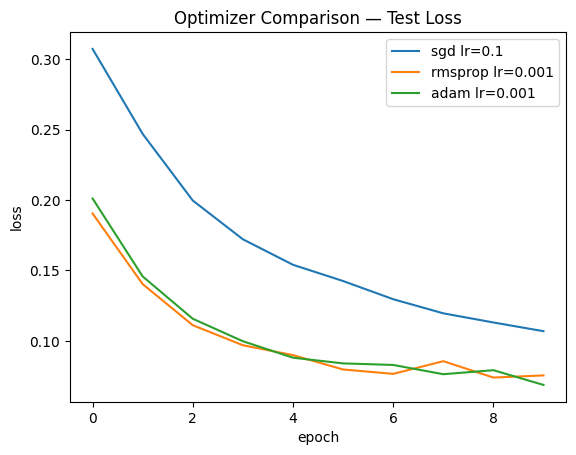

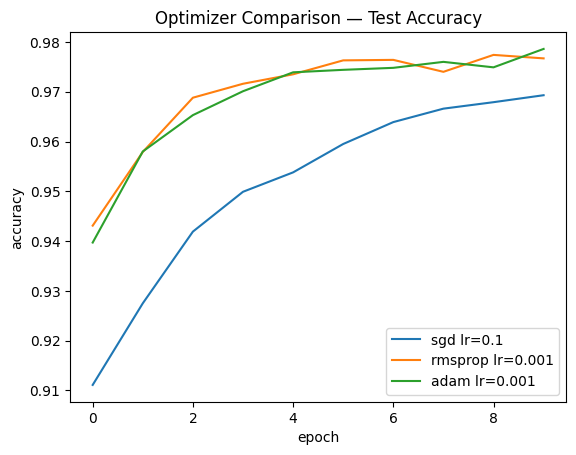

In [17]:
# Compare optimizers (keep epochs small first)
configs = [
    ("sgd",     "constant", 10, 0.1),
    ("rmsprop", "constant", 10, 0.001),
    ("adam",    "constant", 10, 0.001),
]

results = {}
for opt_name, sched, ep, lr in configs:
    print("\n====", opt_name.upper(), "====")
    results[(opt_name, sched, lr)] = train_with_optimizer(opt_name=opt_name, schedule=sched, epochs=ep, base_lr=lr)

# Plot convergence (test loss)
plt.figure()
for (opt_name, sched, lr), hist in results.items():
    plt.plot(hist["test_loss"], label=f"{opt_name} lr={lr}")
plt.title("Optimizer Comparison — Test Loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
plt.show()

# Plot convergence (test accuracy)
plt.figure()
for (opt_name, sched, lr), hist in results.items():
    plt.plot(hist["test_acc"], label=f"{opt_name} lr={lr}")
plt.title("Optimizer Comparison — Test Accuracy")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
plt.show()



==== SGD schedule: constant ====
SGD     | constant | epoch 01 | test acc 0.9140 | lr 0.10000
SGD     | constant | epoch 02 | test acc 0.9298 | lr 0.10000
SGD     | constant | epoch 03 | test acc 0.9419 | lr 0.10000
SGD     | constant | epoch 04 | test acc 0.9501 | lr 0.10000
SGD     | constant | epoch 05 | test acc 0.9535 | lr 0.10000
SGD     | constant | epoch 06 | test acc 0.9588 | lr 0.10000
SGD     | constant | epoch 07 | test acc 0.9611 | lr 0.10000
SGD     | constant | epoch 08 | test acc 0.9633 | lr 0.10000
SGD     | constant | epoch 09 | test acc 0.9665 | lr 0.10000
SGD     | constant | epoch 10 | test acc 0.9682 | lr 0.10000
SGD     | constant | epoch 11 | test acc 0.9697 | lr 0.10000
SGD     | constant | epoch 12 | test acc 0.9714 | lr 0.10000

==== SGD schedule: step ====
SGD     | step    | epoch 01 | test acc 0.9114 | lr 0.10000
SGD     | step    | epoch 02 | test acc 0.9307 | lr 0.10000
SGD     | step    | epoch 03 | test acc 0.9418 | lr 0.10000
SGD     | step    | epoc

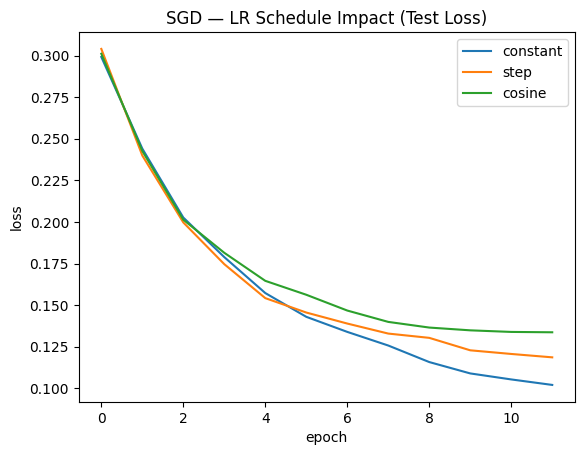

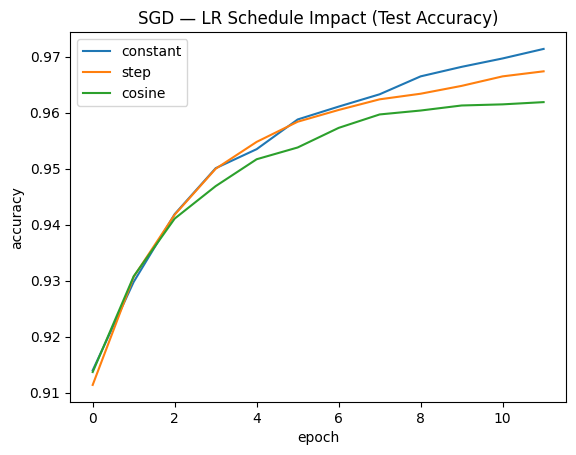

In [18]:
# Learning rate schedule impact (example: SGD)
sched_results = {}
for sched in ["constant", "step", "cosine"]:
    print("\n==== SGD schedule:", sched, "====")
    sched_results[sched] = train_with_optimizer(opt_name="sgd", schedule=sched, epochs=12, base_lr=0.1)

plt.figure()
for sched, hist in sched_results.items():
    plt.plot(hist["test_loss"], label=sched)
plt.title("SGD — LR Schedule Impact (Test Loss)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
plt.show()

plt.figure()
for sched, hist in sched_results.items():
    plt.plot(hist["test_acc"], label=sched)
plt.title("SGD — LR Schedule Impact (Test Accuracy)")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
plt.show()


**Optimizer Analysis.**  
SGD converges slower due to a fixed learning rate and lack of adaptivity.  
RMSprop and Adam achieve faster convergence by adjusting step sizes per parameter.  
Adam shows the best stability and final performance on MNIST.

**Learning Rate Schedules.**  
Constant learning rate achieved the lowest final loss in this setup.  
Step and cosine schedules provide smoother convergence but slightly worse final accuracy.
